# Compaction using Learned Indexes

Python colab notebook showing how merging two lists given a CDF would like.

The hypothesis is that if we have a CDF of the lists being merged, we can speed up merging. This would in turn help in speeding up the compaction process in LSM tree like structures.

There are two approaches we could take here:

1. Sort using the CDF, while being agnostic to how the CDF was built.
2. Exploit the underlying CDF structure (line segments in the case of PLR) to do the merging.

This python notebook is mostly focused on 1. 
We'll explore 2, later.


---
### Credit

- GreedyPLR (Taken from [RyanMarcus/plr](https://github.com/RyanMarcus/plr)) 


In [ ]:
import numpy as np
import random
from matplotlib import pyplot as plt

## Greedy PLR 


```python
# Array to plot CDF for.
# Ensure no duplicates in the array.
x = [...] 
x.sort()
# Empirical CDF
y = [1.0 / len(x) * i for i in range(0, x))]

# Pack the data
data = list(zip(x, y))

# 0.05 is gamma, how tightly you want to fit the data.
# smaller values might lead to overfitting.
# larger values might suffer in accuracy.
lines = train_greedyPLR(0.05, data)

# Use cdf_plr and length to approximate rank. 
k = ...
approx_rank_of_k = cdf_plr(lines, k) * len(x)

```

In [ ]:
# Greedy PLR Code 

def slope(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return (y2 - y1) / (x2 - x1)

# a x + b = y
# ax + b - y = 0
# ax - y = -b

def line(p1, p2):
    a = slope(p1, p2)
    b = -a * p1[0] + p1[1] #y = mx+c -> c = -mx + y 
    return (a,b) #a,b has m and c

def intersection(l1, l2):
    a, c = l1
    b, d = l2
    
    return ((d - c) / (a - b)), ((a*d - b*c)/(a - b))

def above(pt, line):
    return pt[1] > line[0] * pt[0] + line[1]

def below(pt, line):
        return pt[1] < line[0] * pt[0] + line[1]

def upper_bound(pt, gamma):
    return (pt[0], pt[1] + gamma)

def lower_bound(pt, gamma):
    return (pt[0], pt[1] - gamma)

In [ ]:
class GreedyPLR:
    def __init__(self, gamma):
        self.__state = "need2"
        self.__gamma = gamma
        
    def process(self, pt):
        self.__last_pt = pt
        if self.__state == "need2":
            self.__s0 = pt
            self.__state = "need1"
        elif self.__state == "need1":
            self.__s1 = pt
            self.__setup()
            self.__state = "ready"
        elif self.__state == "ready":
            return self.__process(pt)
        else:
            assert False
    
    def __setup(self):
        self.__rho_lower = line(upper_bound(self.__s0, self.__gamma),
                                lower_bound(self.__s1, self.__gamma))
        self.__rho_upper = line(lower_bound(self.__s0, self.__gamma),
                                upper_bound(self.__s1, self.__gamma))
        
        self.__sint = intersection(self.__rho_lower, self.__rho_upper)
        
    def __current_segment(self):
        segment_start = self.__s0[0]
        segment_stop = self.__last_pt[0]
        avg_slope = (self.__rho_lower[0] + self.__rho_upper[0]) / 2
        intercept = -avg_slope * self.__sint[0] + self.__sint[1]
        return (segment_start, segment_stop, avg_slope, intercept)
        
    def __process(self, pt):
        if not (above(pt, self.__rho_lower) and below(pt, self.__rho_upper)):
            # we have to start a new segment.
            prev_segment = self.__current_segment()
            
            self.__s0 = pt
            self.__state = "need1"
            
            # return the previous segment
            return prev_segment
        
        # we can tweak our extreme slopes to account for this point.
        # if this point's upper bound is below the current rho_upper,
        # we have to change rho_upper.

        s_upper = upper_bound(pt, self.__gamma)
        s_lower = lower_bound(pt, self.__gamma)
        if below(s_upper, self.__rho_upper):
            self.__rho_upper = line(self.__sint, s_upper)
        
        # if this point's lower bound is above the current rho_lower,
        # we have to change rho_lower
        if above(s_lower, self.__rho_lower):
            self.__rho_lower = line(self.__sint, s_lower)
            
        return None
    
    def finish(self):
        if self.__state == "need2":
            self.__state = "finished"
            return None
        elif self.__state == "need1":
            self.__state = "finished"
            return (self.__s0[0], self.__s0[0] + 1, 0, self.__s0[1])
        elif self.__state == "ready":
            self.__state = "finished"
            return self.__current_segment()
        else:
            assert False
        

In [ ]:
def train_greedyPLR(g, data):
  plr_ = GreedyPLR(g)
  lines_ = []
  for pt in data:
    l = plr_.process(pt)
    if l:
      lines_.append(l)
    
  last = plr_.finish()
  if last:
    lines_.append(last)
  return lines_

def plot_lines(data, lines):
  for l in lines:
    xl = np.linspace(l[0], l[1], 100)
    yl = l[2] * xl + l[3]
    plt.scatter(xl, yl)
  plt.scatter(*zip(*data), s=16)


# CDF using PLR
def cdf_plr(lines, x):
  for l in lines:
    if x >= l[0] and x <= l[1]:
      return l[2] * x + l[3] #gives the probability
  return 1.0




## Merging sorted lists using CDF

#### Sort Functions

In [ ]:
import math
# Given a list of tuples that describe the data to be filled in the array, 
# build the array and it's empirical CDF function.
# Each tuple is an array of 3 elements - 
# Insert seg[0] elements, each between (seg[1], seg[2])
def build_list(list_segs):
  x = []
  for seg in list_segs:
    # Insert seg[0] elements, each between (seg[1], seg[2])
    for i in range(0, seg[0]):
      d = random.randint(seg[1], seg[2])
      while d in x:
        d = random.randint(seg[1], seg[2])
      x.append(d)
  return x

def build_emp_cdf(x):
  x.sort()
  y = [1.0 / len(x) * i for i in range(0, len(x))] 
  return list(zip(x, y))


def GuessPostionPLR(data, lines, x):
  return cdf_plr(lines, x) * len(data) #probability * total length = x

def GuessPostionPerfect(data, lines, x):
  for i in range(0, len(data)):
    if (data[i] > x):
      return i
  return len(data)

def plot_data(data, lines):
  plt.figure(figsize=(20, 5))
  for i in range(len(data)):
    plt.subplot(1, len(data), i+1)
    plt.title("CDF of data_set_" + str(i+1))
    plot_lines(data[i], lines[i])


def merge_lists(lists): #merges n sorted lists into a single sorted list (standard merge)
  n = len(lists)
  pos = [0 for i in range(n)]
  result = []
  num_comp = 0
  while True:
    s = -1
    for i in range(n):
      if pos[i] == len(lists[i]):
        continue
      if s == -1:
        s = i
        continue
      num_comp+=1
      if lists[s][pos[s]] > lists[i][pos[i]]:
        s = i
    if s == -1:
      break
    result.append(lists[s][pos[s]])
    pos[s] += 1
  return (result, num_comp)

def merge_lists_cdf(lists, lines, cdf):
  n = len(lists)
  pos = [0 for i in range(n)]
  result = []
  num_comp = 0
  cdf_error = 0


  while True:
    s0 = -1  # smallest
    ss = -1  # second_smallest

    for i in range(n):
      if pos[i] == len(lists[i]):
        continue
      if s0 == -1:
        s0 = i
        continue
    
      if lists[s0][pos[s0]] > lists[i][pos[i]]:
        ss = s0
        s0 = i
        num_comp+=1
      elif ss == -1:
        ss = i
        num_comp+=1
      elif lists[ss][pos[ss]] > lists[i][pos[i]]:
        ss = i
        num_comp+=2
      else:
        num_comp+=2 
  
    if s0 == -1:
      break

    if ss == -1:
      for i in range(pos[s0], len(lists[s0])):
        result.append(lists[s0][pos[s0]])
        pos[s0] += 1
  
    else:
      #limit = GuessPostionPerfect(lists[s0], lines, lists[ss][pos[ss]])
      limit = cdf(lists[s0], lines[s0], lists[ss][pos[ss]])
      limit = math.floor(limit)
      if limit < 0:
        limit = 0
      if limit >= len(lists[s0]):
        limit = len(lists[s0])-1

      while limit > 0 and lists[s0][limit] > lists[ss][pos[ss]]:
        cdf_error += 1
        limit -= 1
      
      # Could we reduce this using binary search?
      while limit < len(lists[s0]) and (limit <= 0 or lists[s0][limit] <= lists[ss][pos[ss]]):
        cdf_error += 1
        limit += 1
      
      for i in range(pos[s0], limit):
        result.append(lists[s0][pos[s0]])
        pos[s0] += 1

  return (result, num_comp, cdf_error)





In [ ]:
def analyze(data_to_merge, gamma):
  emp_cdf_list = [build_emp_cdf(d) for d in data_to_merge]
  cdf_list = [train_greedyPLR(gamma, emp_cdf) for emp_cdf in emp_cdf_list]
  plot_data(emp_cdf_list, cdf_list)


  merged_gplr, nc_gplr, error_gplr = merge_lists_cdf(data_to_merge[0:3], cdf_list, GuessPostionPLR)
  merged_perf, nc_perf, error_perf = merge_lists_cdf(data_to_merge[0:3], cdf_list, GuessPostionPerfect)
  merged, nc1 = merge_lists(data_to_merge[0:3])

  plt.figure()
  x = ["Standard MergeSort", "GreedyPLR", "PerfectCDF"]
  y = [nc1, nc_gplr + error_gplr, nc_perf + error_perf]
  plt.title("Total comparisions = Num Comparisions + Error from CDF")
  plt.bar(x, y, width = 0.4, label="error_correction")
  y = [nc1, nc_gplr, nc_perf]
  plt.bar(x, y, width = 0.4)


  assert(merged == merged_gplr)

## Test Runs

#### Test Data

In [ ]:
test_300 = [
  # list 1 has 100 elements, skewed to be between 0, 600
  build_list([
    (90, 0, 600),
    (10, 600, 1000)
  ]),
  # list 2 has 100 elements, skewed to be between 600, 1000
  build_list([
    (10, 0, 600),
    (90, 600, 1000)
  ]),
  # list 3 has 100 elements, skewed to be between 400, 600
  build_list([
    (5, 0, 400),
    (90, 400, 600),
    (5, 600, 1000),
  ])
]

test_3000 = [
  # list 1 has 1000 elements, skewed to be between 0, 6000
  build_list([
    (900, 0, 6000),
    (100, 6000, 10000)
  ]),
  # list 2 has 1000 elements, skewed to be between 6000, 10000
  build_list([
    (100, 0, 6000),
    (900, 6000, 10000)
  ]),
  # list 3 has 1000 elements, skewed to be between 4000, 6000
  build_list([
    (50, 0, 4000),
    (900, 4000, 6000),
    (50, 6000, 10000),
  ])

]

### 300 elements, Gamma = 0.5


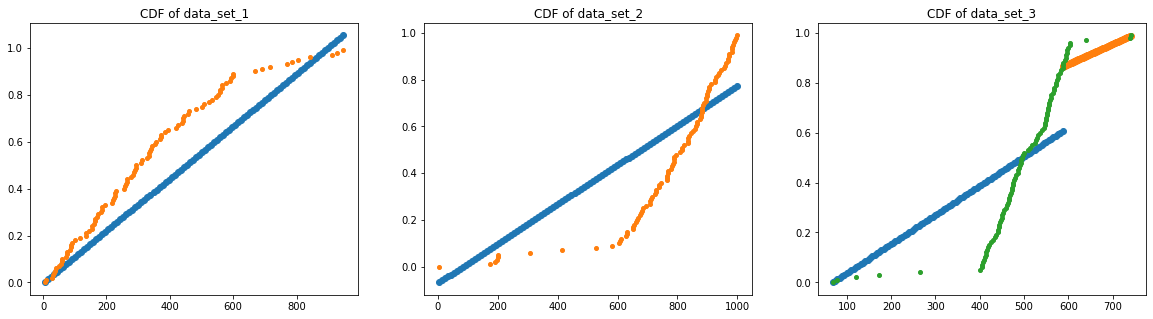

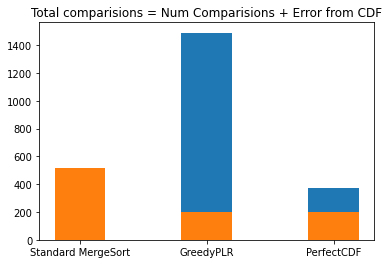

In [ ]:
analyze(test_300, 0.5)

### 300 elements, Gamma = 0.05

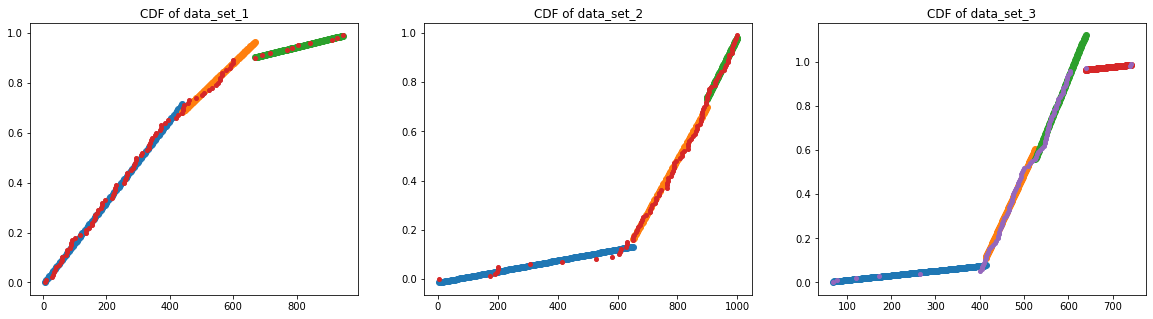

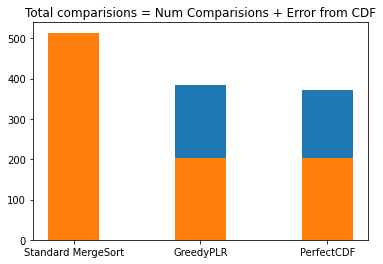

In [ ]:
analyze(test_300, 0.05)

### 3000 tests, gamma = 0.05, 0.005

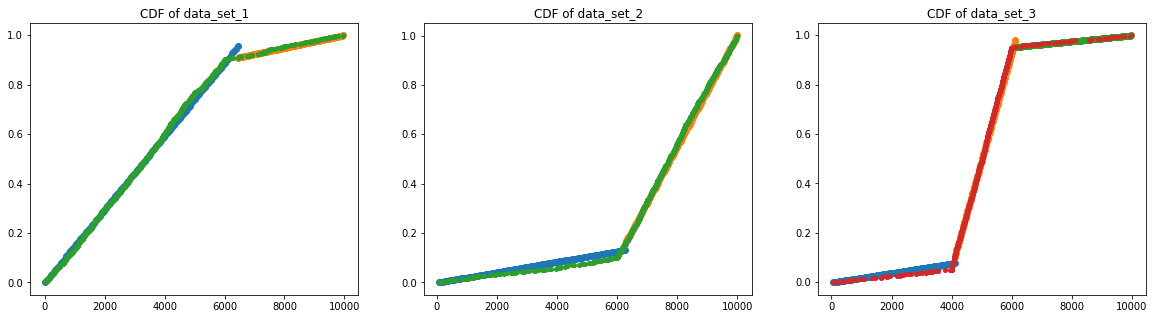

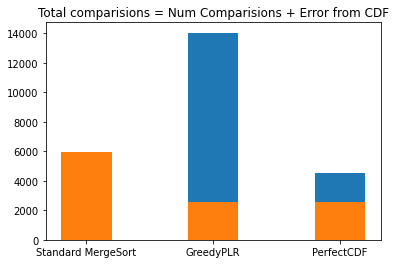

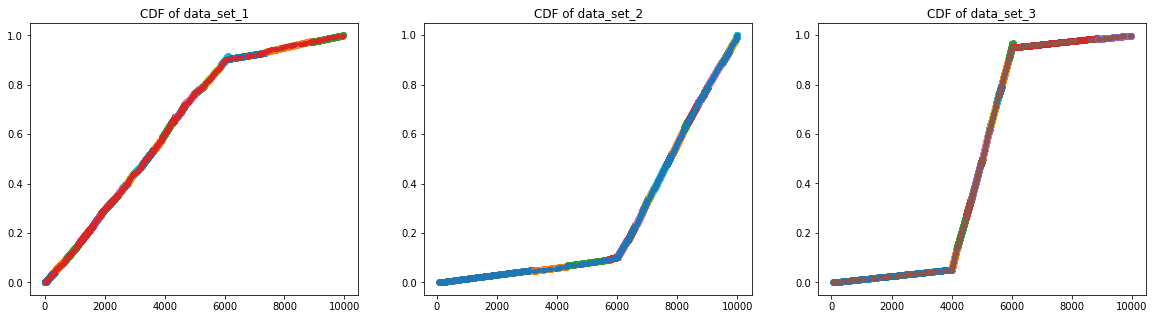

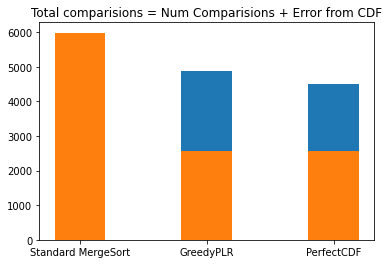

In [ ]:
analyze(test_3000, 0.05)
analyze(test_3000, 0.005)